In [5]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

c:\Users\Abhishek\Desktop\langgraph_learning\langgraph_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
load_dotenv()

True

In [7]:
Google_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [8]:
Google_model.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--660f0f03-9799-47cf-90ad-4ed6adc66a02-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 36, 'input_token_details': {'cache_read': 0}})

Demo-Project 1

In [10]:
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

add_numbers(state)
state={"num1":1, "num2":2}

additional result: 3


In [11]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [12]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [13]:
model_with_tool=Google_model.bind_tools([transfer_to_multiplication_expert])

In [14]:
ai_message=model_with_tool.invoke("hi how are you?")

Below we are checking whether any tool call had been made!

In [15]:
ai_message.tool_calls

[]

In [16]:
ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [17]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': '34005425-9e18-4e8d-b43b-afd0d3bbd6d8',
  'type': 'tool_call'}]

In [ ]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = Google_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    # If any tool call was made
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    #else return message if no tool call
    return {"messages": [ai_msg]}

In [25]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = Google_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [27]:
graph=StateGraph(MessagesState)

graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [28]:
graph.add_edge(START, "additional_expert")

In [29]:
app = graph.compile()

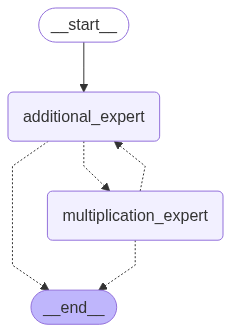

In [30]:
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='e24c17fa-b552-4036-af5d-fcbb2b5bb893'),
  AIMessage(content="I can help you with the addition part. 3 + 5 = 8.\nNow we need to multiply 8 by 12. I'll transfer this to the multiplication expert.", additional_kwargs={'function_call': {'name': 'transfer_to_multiplication_expert', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--2134ffa3-7c90-4322-9efd-2a7cc8b16f2b-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'c3b566e5-5ccd-492a-85b8-2c7a061fba4a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 56, 'total_tokens': 243, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Successfully transferred', id='8fdf40b6-8327-48e0-8bbb-d0d2f580d0f2', tool_call_id='c3b566e5-5ccd-492a-85b8-2

In [32]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [33]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================

The sum of 3 and 5 is 8. I'll transfer this to the multiplication expert to calculate 8 * 12.
Tool Calls:
  transfer_to_multiplication_expert (985fb280-74aa-4898-a2b9-587deb9f4302)
 Call ID: 985fb280-74aa-4898-a2b9-587deb9f4302
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_addition_expert (698c0ea4-03ae-477c-8254-10500c6123bc)
 Call ID: 698c0ea4-03ae-477c-8254-10500c6123bc
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node additional_expert:


================================== Ai Message ================================

Demo-Project 2

In [34]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [35]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [36]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [37]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [38]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

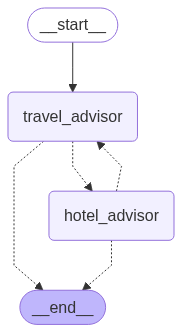

In [39]:
app = graph_builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?', additional_kwargs={}, response_metadata={}, id='66425f80-c1c1-4d2a-8c1d-a7ca1017c542'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yt3dhjwk6', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_advisor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 290, 'prompt_tokens': 179, 'total_tokens': 469, 'completion_time': 1.412664098, 'prompt_time': 0.013924668, 'queue_time': 0.27683873200000003, 'total_time': 1.426588766}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_87eae35036', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--510931e6-4f09-4068-b2a4-25d5a26eedfc-0', tool_calls=[{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'yt3dhjwk6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 290, '

In [43]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (aepsp0g66)
 Call ID: aepsp0g66
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_travel_advisor (xnmj92xgb)
 Call ID: xnmj92xgb
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

Sure! I'd be happy to help you plan your trip to California. For hotel recommendations, I'll transfer you to the hotel advisor.




In [44]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from Mumbai to California, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (798wn6v8q)
 Call ID: 798wn6v8q
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

I'm here to help with hotel recommendations! If you need assistance with flight options, I recommend reaching out to a travel advisor. For hotel recommendations, feel free to share your destination and preferences, and I'll be happy to assist!


